## Tutorial: Read mismatch analysis
In this tutorial, we showcase rnalib's ReadIterator's `report_mismatches` feature which reports reference/read mismatches (possibly filtered by minimum basecalling quality). Briefly, we do the following:

* iterate over alignment and report mismatches, so returned item.data is a tuple (read, mismatches)
* ref/alt alleles are revcomped if read is reversed (strand specific)
* count and plot results

In [1]:
import os, pathlib, platform
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np

# load rnalib
import rnalib as rna
from rnalib import gi, SEP, display_textarea
plt.rcParams["figure.figsize"] = (20,3)

display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")

'Running rnalib 1.0.0 on python 3.10.4'

## Test datasets

This notebook as well as rnalib's testing suite use various test resources (genomics data files and indexing structures) that can be created by 
running the rnalib `rnalib_create_testdata` script or by calling the `testdata.create_testdata()` method. There are two seperate resource sets:

* test_resources: small test datasets that are used by rnalib's test suite
* large_test_resources: larger test files that are needed to demonstrate rnalib under realistic conditions. 

Rnalib knows about the test data directory via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by monkeypatching (rna.__RNALIB_TESTDATA__ = <mydir>) as shown below. Once this is done, test data resources can be accessed via 
`get_resource(<resource_id>)`. Rnalib will recreate these resources only if they are not found in the provided output folder.


In [4]:
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/"

if not os.path.isdir(rna.__RNALIB_TESTDATA__):
    os.mkdir(rna.__RNALIB_TESTDATA__)
    display("Creating testdata at {rna.__RNALIB_TESTDATA__ }")
    rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, 
                                 rna.testdata.test_resources)
else:
    display(f"Testdata at {rna.__RNALIB_TESTDATA__}")
    rna.print_dir_tree(rna.__RNALIB_TESTDATA__)

'Testdata at rnalib_testdata/'

├── bigfiles
│   ├── grch38_chr20.fa.gz.gzi
│   ├── chess3.0.1.gtf.gz
│   ├── gencode_39.gff3.gz
│   ├── hgnc_complete_set.txt
│   ├── gencode_39.gff3.gz.tbi
│   ├── grch38_chr20.fa.gz
│   ├── GRCh38.k24.umap.bedgraph.gz
│   ├── grch38_chr20.fa.gz.fai
│   ├── chess3.0.1.gtf.gz.tbi
│   └── GRCh38.k24.umap.bedgraph.gz.tbi
├── bed
│   ├── test_bed12.bed.gz.tbi
│   ├── test_bed12.bed.gz
│   ├── test.bed.gz
│   ├── test.bedgraph.gz
│   ├── pybedtools_snps.bed.gz
│   ├── test_nist.b37_chr20_100kbp_at_10mb.bed
│   ├── dmel_randomvalues.bedgraph.gz
│   ├── GRCh38.k24.umap.ACTB_ex1+2.bedgraph.gz
│   ├── dmel_randomvalues.bedgraph.gz.tbi
│   ├── test.bedgraph.gz.tbi
│   └── ...
├── div
│   └── hgnc_complete_set.head.txt.gz
├── bam
│   ├── NA12878_S1.chr20.10_10p1mb.bam
│   ├── mapt.NA12156.altex.small.bam
│   ├── NA12878_S1.chr20.10_10p1mb.bam.bai
│   ├── mapt.NA12156.altex.small.bam.bai
│   ├── rogue_read.bam.bai
│   ├── rogue_read.bam
│   ├── small.ACTB+SOX2.bam.bai
│   ├── small_example.bam
│

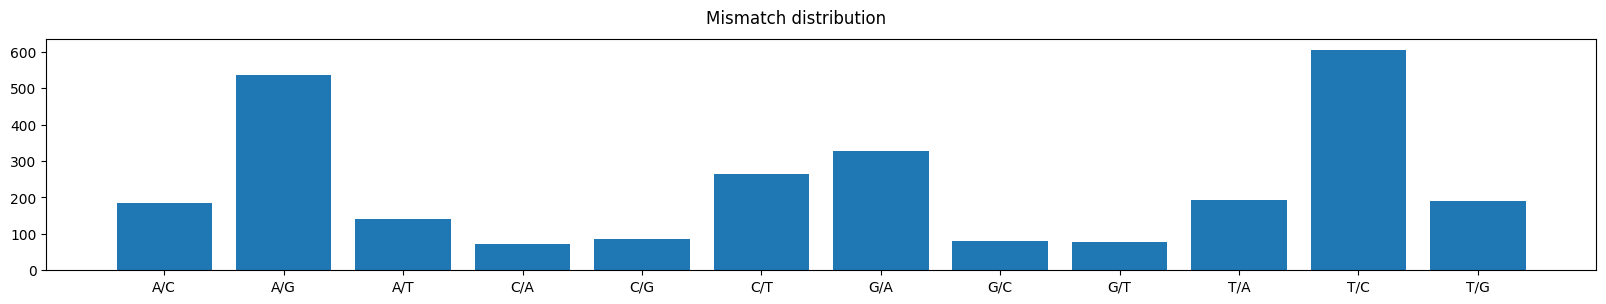

In [5]:
# Calculate mismatch profile and plot. 
profile=Counter()
for l,(r,mm) in rna.ReadIterator(rna.get_resource('small_example_bam'),report_mismatches=True, min_base_quality=10):
    is_rev = not r.is_reverse if r.is_read2 else r.is_reverse # properly deal with PE data
    for (readpos, genpos, ref, alt) in mm: # reported mismatches contain position in read, genomic position, reference and alternate allele
        if is_rev: # correct for read strand
            ref,alt=rna.reverse_complement(ref),rna.reverse_complement(alt)
        profile[f"{ref}/{alt}"]+=1
# plot the data
labels, values = zip(*sorted(profile.items()))
plt.bar(range(len(labels)), values, 0.8)
plt.xticks(range(len(labels)), labels)
plt.suptitle("Mismatch distribution")
plt.show()

Using this feature, we  can  also easily count mismatches of a certain type (e.g., T/C mismatches as found in a SLAMseq dataset)

In [6]:
# count T/C (A/G) mismatches per read in a BAM file, filtering for minimum base quality
tc_conv={}
for l,(r,mm) in rna.ReadIterator(rna.get_resource('small_example_bam'),report_mismatches=True, min_base_quality=10):
    if len(mm)>0: # at least 1 mismatch - just to speed things up.
        is_rev = not r.is_reverse if r.is_read2 else r.is_reverse
        refc = "A" if is_rev else "T"
        altc = "G" if is_rev else "C"
        mm_tc=[(off, pos1, ref, alt) for off, pos1, ref, alt in mm if ref==refc and alt==altc] # get only T/C or A/G mismatches (depending on read strand)
        if len(mm_tc) > 0: # at least 1 T/C or A/G mm
            tc_conv[r.query_name, not r.is_read2]=mm_tc

# show the first 10 reads
display('10 reads and their mismatches', {k:tc_conv[k] for k in list(tc_conv.keys())[:10]}, SEP)

# count reads with more than one T/C conversion
display('Number of reads with more than one T/C conversion', len({k:tc_conv[k] for k in list(tc_conv.keys()) if len(tc_conv[k])>1}),SEP)

# show MM of one such read
display('Example read with 2 mismatches:', tc_conv['HWI-ST466_135068617:8:2316:4251:54002', False],  SEP)

'10 reads and their mismatches'

{('HWI-ST466_135068617:8:1104:18372:89212', False): [(2, 22379204, 'A', 'G')],
 ('HWI-ST466_135068617:8:2114:8986:54547', False): [(98, 22404991, 'T', 'C')],
 ('HWI-ST466_135068617:8:2214:18036:44964', False): [(86, 22404981, 'A', 'G')],
 ('HWI-ST466_135068617:8:2301:15221:88708', True): [(71, 22404968, 'A', 'G')],
 ('HWI-ST466_135068617:8:1107:12866:40944', False): [(72, 22404971, 'A', 'G')],
 ('HWI-ST466_135068617:8:2101:20690:68324', False): [(78, 22404984, 'A', 'G')],
 ('HWI-ST466_135068617:8:1102:11736:16410', True): [(53, 22404966, 'T', 'C')],
 ('HWI-ST466_135068617:8:1103:20561:79535', True): [(52, 22404966, 'T', 'C')],
 ('HWI-ST466_135068617:8:2308:21226:40688', False): [(25, 22404940, 'A', 'G')],
 ('HWI-ST466_135068617:8:1303:15014:31681', False): [(2, 22379925, 'A', 'G')]}

---

'Number of reads with more than one T/C conversion'

25

---

'Example read with 2 mismatches:'

[(2, 22443997, 'A', 'G'), (5, 22444000, 'A', 'G')]

---

Now, we slightly extend this example by

* counting only T/C (A/G on reverse strand) mismatches per chromosome
* count also the number of unconverted (i.e., ref==T) positions
* Create a pandas dataframe with these counts and filter rows for minimum couts
* Show a filtered dataset of entries with 20-22 convertible positions, the number of converted positions and the number of such reads  found

In [7]:
# Count T/C (A/G) mismatches per chromosome.
bam_file=rna.get_resource('small_example_bam')

# Count the mismatches; 
profile=Counter()
with rna.ReadIterator(bam_file,report_mismatches=True, min_base_quality=10) as it:
    # calculate the number of reads from the BAM index
    n_reads=sum([x.total for x in it.file.get_index_statistics()])
    for l,(r,mm) in tqdm(it, total=n_reads):
        is_rev = not r.is_reverse if r.is_read2 else r.is_reverse
        refc = "A" if is_rev else "T"
        altc = "G" if is_rev else "C"
        for (readpos, genpos, ref, alt) in mm:
            n_ref = r.query_sequence.count(refc)
            mm_tc=[(off, pos1, ref, alt) for off, pos1, ref, alt in mm if ref==refc and alt==altc]
            profile[r.reference_name,refc,altc,n_ref,len(mm_tc)]+=1
    # show stats
    display(it.stats)

# filter for min number of counts
profile=pd.DataFrame([list(k)+[v] for k,v in profile.items()], columns=['chromosome','ref','alt', 'convertible','converted', 'count'])
profile=profile[profile['count']>10]

# show filtered data, grouped by strand and convertible positions
fil=profile.query('20 <= convertible <= 22').sort_values(['convertible', 'converted'])
fil['conv']=fil['ref']+"/"+fil['alt']
grouped=fil.groupby(['conv', 'convertible'])
for i, key in enumerate(grouped.groups.keys()):
    dat=grouped.get_group(key).set_index('conv')
    display(dat)

  0%|          | 0/31678 [00:00<?, ?it/s]

Counter({('iterated_items', None): 31678,
         ('yielded_items', '1'): 21932,
         ('n_fil_flag', '1'): 9746})

,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
A/G,1,A,G,20,0,41


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
A/G,1,A,G,21,0,37


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
A/G,1,A,G,22,0,50
A/G,1,A,G,22,1,11


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
T/C,1,T,C,20,0,21


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
T/C,1,T,C,21,0,44
T/C,1,T,C,21,1,44
T/C,1,T,C,21,2,14


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
T/C,1,T,C,22,0,58
T/C,1,T,C,22,1,41


TODO count converted reads per transcript/exon.